<a href="https://colab.research.google.com/github/sungbaejo/serverless_region/blob/master/knu_master_degree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Serverless Region별 성능 비교에 따른 최적 Region 선택 학습 모델
---


*   Serverless 환경 : Google Firebase (GCP)
*   Checkpoint 서비스 : https://www.uptrends.com/ (Monitor log excel export)
*   Checkpoint 위치 : France(Paris), Germany(Berlin,Frankfurt), Italy(Milan), Netherlands(Amsterdam), United Kingdom(London), Canada(Montreal), United States(Dallas, New York, San Diego)
*   Log 수집 기간 : 2019/11/11~2020/03/09 (리전별 2분 간격, Checkpoint는 Random, 총 524174건의 로그) 






In [1]:
# Requires the latest pip
!pip install --upgrade pip

# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

!pip install sklearn

#!pip install --upgrade pandas


# For a specific version:
#!pip install tensorflow==2.1

# For the latest nightly build:
#!pip install tf-nightly

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, gast, wrapt, keras-applications, google-pasta, protobuf, opt-einsum, grpcio, wheel, numpy, astor, termcolor, six, tensorflow-estimator, keras-preprocessing, absl-py, tensorboard
Required-by: stable-baselines, magenta, fancyimpute
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [2]:
# Use seaborn for pairplot
!pip install -q seaborn

!pip install pandas
#!pip install --upgrade pandas

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
print(sys.version_info)

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.1.0


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1YQs2XR3n-FGjn-bDaqXqKWjXeFtFd8Oi'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile ('log.csv') #directory : content
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [7]:
raw_dataset = pd.read_csv('log.csv', thousands=',')

df = raw_dataset.copy()
df.tail()

ErrorLevel              Timestamp  ... DownloadTime  DownloadSize
524169   No error  11/11/2019 7:53:20 PM  ...            0           558
524170   No error  11/11/2019 7:52:31 PM  ...            0           558
524171   No error  11/11/2019 7:51:55 PM  ...            0           558
524172   No error  11/11/2019 7:51:22 PM  ...            0           558
524173   No error  11/11/2019 7:50:58 PM  ...            0           558

[5 rows x 12 columns]

In [8]:
df.isna().sum()

ErrorLevel         0
Timestamp          0
Region             0
RTT                0
StatusCode         0
Description        0
Checkpoint         0
IP                43
ResolveTime        0
ConnectionTime     0
DownloadTime       0
DownloadSize       0
dtype: int64

In [9]:
print(len(df))
print(df.ErrorLevel.unique())

524174
['No error' 'Confirmed error' 'Unconfirmed error']


In [10]:
df.drop(df[df.ErrorLevel != "No error"].index, inplace=True)
print(len(df))
print(df.ErrorLevel.unique())

522304
['No error']


In [11]:
print(df.StatusCode.unique())
print(df.Description.unique())
print(df.ResolveTime.unique())
print(df.ConnectionTime.unique())
print(df.DownloadTime.unique())
print(df.DownloadSize.unique())

[0]
['OK']
[0]
[0]
[0]
[558 554 556]


In [12]:
df.drop(columns=['ErrorLevel', 'StatusCode', 'Description', 'IP', 'ResolveTime', 'ConnectionTime', 'DownloadTime', 'DownloadSize'], inplace=True)
print(len(df))
df.tail()

522304


Timestamp           Region   RTT Checkpoint
524169  11/11/2019 7:53:20 PM     europe-west2   156      Milan
524170  11/11/2019 7:52:31 PM  asia-northeast1  2939      Milan
524171  11/11/2019 7:51:55 PM  asia-northeast1   276   New York
524172  11/11/2019 7:51:22 PM     europe-west2  1161     Dallas
524173  11/11/2019 7:50:58 PM     europe-west2   228  Frankfurt

In [13]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format = '%m/%d/%Y %I:%M:%S %p')
df['Timestamp'].tail()

524169   2019-11-11 19:53:20
524170   2019-11-11 19:52:31
524171   2019-11-11 19:51:55
524172   2019-11-11 19:51:22
524173   2019-11-11 19:50:58
Name: Timestamp, dtype: datetime64[ns]

In [14]:
df.sort_values(by=['Timestamp'], inplace=True)
df['Timestamp'].tail()

4   2020-03-09 13:41:12
3   2020-03-09 13:41:22
2   2020-03-09 13:41:39
1   2020-03-09 13:41:47
0   2020-03-09 13:42:10
Name: Timestamp, dtype: datetime64[ns]

In [15]:
df.reset_index(drop=True, inplace=True)
df

Timestamp           Region   RTT Checkpoint
0      2019-11-11 19:50:58     europe-west2   228  Frankfurt
1      2019-11-11 19:51:22     europe-west2  1161     Dallas
2      2019-11-11 19:51:55  asia-northeast1   276   New York
3      2019-11-11 19:52:31  asia-northeast1  2939      Milan
4      2019-11-11 19:53:20     europe-west2   156      Milan
...                    ...              ...   ...        ...
522299 2020-03-09 13:41:12         us-east1   152     Dallas
522300 2020-03-09 13:41:22      us-central1   243     Berlin
522301 2020-03-09 13:41:39  asia-northeast1   268   New York
522302 2020-03-09 13:41:47       asia-east2   294  San Diego
522303 2020-03-09 13:42:10     europe-west2    68     London

[522304 rows x 4 columns]

In [16]:
df['Timestamp_year'] = df['Timestamp'].dt.year
df['Timestamp_month'] = df['Timestamp'].dt.month
df['Timestamp_week'] = df['Timestamp'].dt.week
df['Timestamp_day'] = df['Timestamp'].dt.day
df['Timestamp_hour'] = df['Timestamp'].dt.hour
df['Timestamp_minute'] = df['Timestamp'].dt.minute
df['Timestamp_dayofweek'] = df['Timestamp'].dt.dayofweek
df

Timestamp  ... Timestamp_dayofweek
0      2019-11-11 19:50:58  ...                   0
1      2019-11-11 19:51:22  ...                   0
2      2019-11-11 19:51:55  ...                   0
3      2019-11-11 19:52:31  ...                   0
4      2019-11-11 19:53:20  ...                   0
...                    ...  ...                 ...
522299 2020-03-09 13:41:12  ...                   0
522300 2020-03-09 13:41:22  ...                   0
522301 2020-03-09 13:41:39  ...                   0
522302 2020-03-09 13:41:47  ...                   0
522303 2020-03-09 13:42:10  ...                   0

[522304 rows x 11 columns]

In [17]:
df.describe()

RTT  Timestamp_year  ...  Timestamp_minute  Timestamp_dayofweek
count  522304.000000   522304.000000  ...     522304.000000        522304.000000
mean      590.690556     2019.577330  ...         29.484331             3.007501
std       743.541406        0.493984  ...         17.318085             1.996969
min        31.000000     2019.000000  ...          0.000000             0.000000
25%       168.000000     2019.000000  ...         14.000000             1.000000
50%       275.000000     2020.000000  ...         29.000000             3.000000
75%       770.000000     2020.000000  ...         44.000000             5.000000
max     36316.000000     2020.000000  ...         59.000000             6.000000

[8 rows x 8 columns]

In [18]:
df.dtypes

Timestamp              datetime64[ns]
Region                         object
RTT                             int64
Checkpoint                     object
Timestamp_year                  int64
Timestamp_month                 int64
Timestamp_week                  int64
Timestamp_day                   int64
Timestamp_hour                  int64
Timestamp_minute                int64
Timestamp_dayofweek             int64
dtype: object

In [19]:
df['Timestamp_dayofweek'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [20]:
grouper = df[['Region',"RTT"]].groupby(['Region']).count()
grouper.rename(columns={"RTT": "CallCount"})

CallCount
Region                    
asia-east2           86838
asia-northeast1      87030
europe-west1         87085
europe-west2         87118
us-central1          87173
us-east1             87060

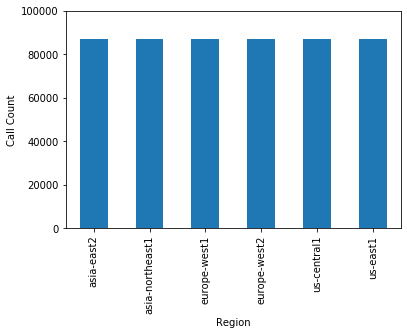

In [21]:
grouper.plot(kind='bar',legend=False)
plt.ylim(0, 100000)
plt.ylabel('Call Count')
plt.show()

In [22]:
grouper = df[['Checkpoint',"RTT"]].groupby(['Checkpoint']).count()
grouper.rename(columns={"RTT": "CallCount"})

CallCount
Checkpoint           
Amsterdam       48942
Berlin          53077
Dallas          57751
Frankfurt       57690
London          48758
Milan           48847
Montreal        48957
New York        56471
Paris           48868
San Diego       52943

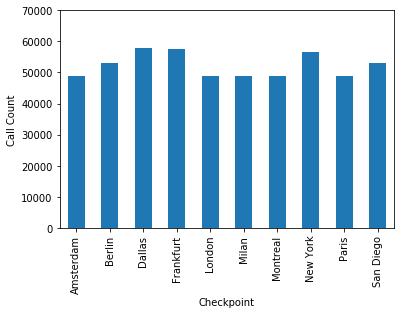

In [23]:
grouper.plot(kind='bar',legend=False)
plt.ylim(0, 70000)
plt.ylabel('Call Count')
plt.show()

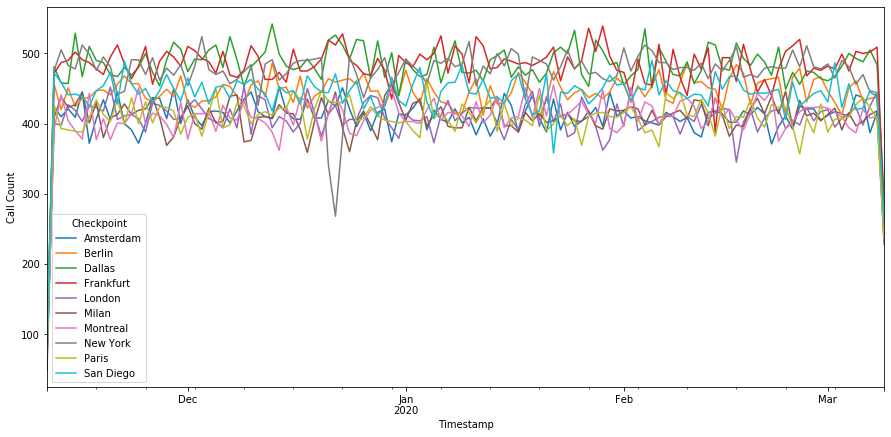

In [24]:
grouper = df.groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Checkpoint'])
mean_result = grouper['RTT'].count().unstack() #필요시 .fillna(0) 추가

fig, ax = plt.subplots(figsize=(15,7))
mean_result.plot(ax=ax)
plt.xlabel("Timestamp")
plt.ylabel("Call Count")
plt.show()

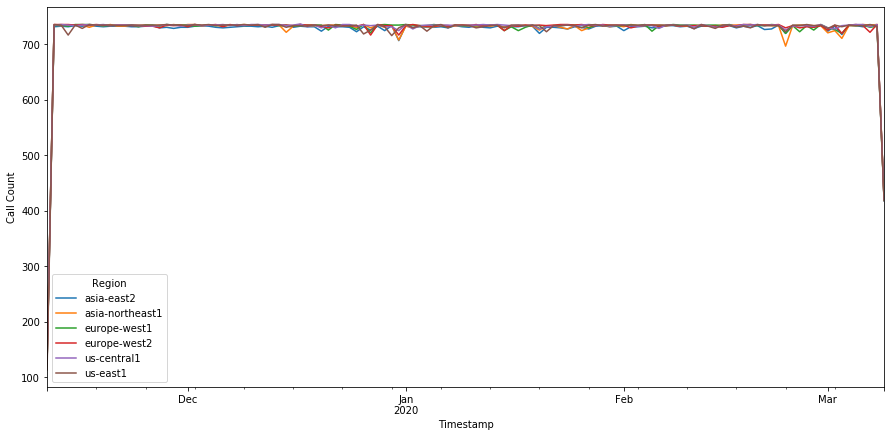

In [25]:
grouper = df.groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Region'])
mean_result = grouper['RTT'].count().unstack() #필요시 .fillna(0) 추가

fig, ax = plt.subplots(figsize=(15,7))
mean_result.plot(ax=ax)
plt.xlabel("Timestamp")
plt.ylabel("Call Count")
plt.show()

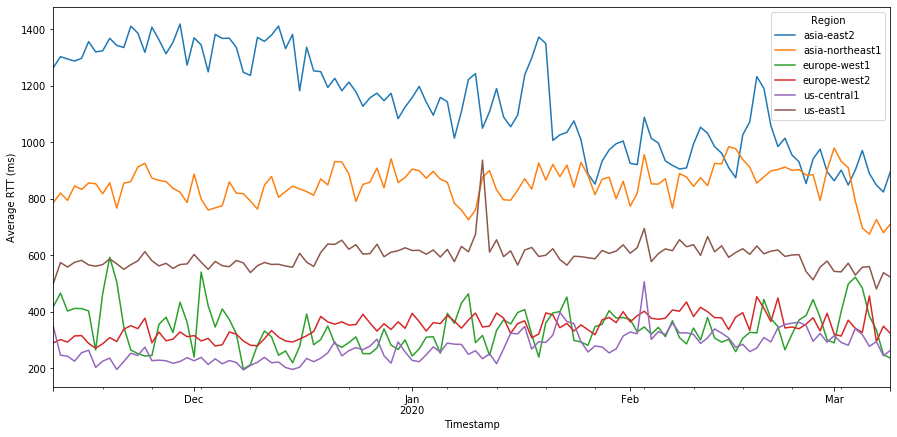

In [44]:
#@title
grouper = df.groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Region'])
mean_result = grouper['RTT'].mean().unstack() #필요시 .fillna(0) 추가

fig, ax = plt.subplots(figsize=(15,7))
mean_result.plot(ax=ax)
plt.xlabel("Timestamp")
plt.ylabel("Average RTT (ms)")
plt.show()

europe-west2


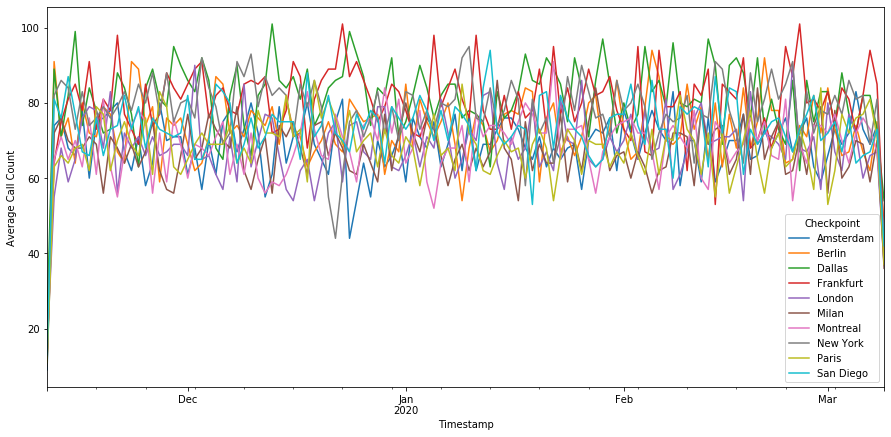

asia-northeast1


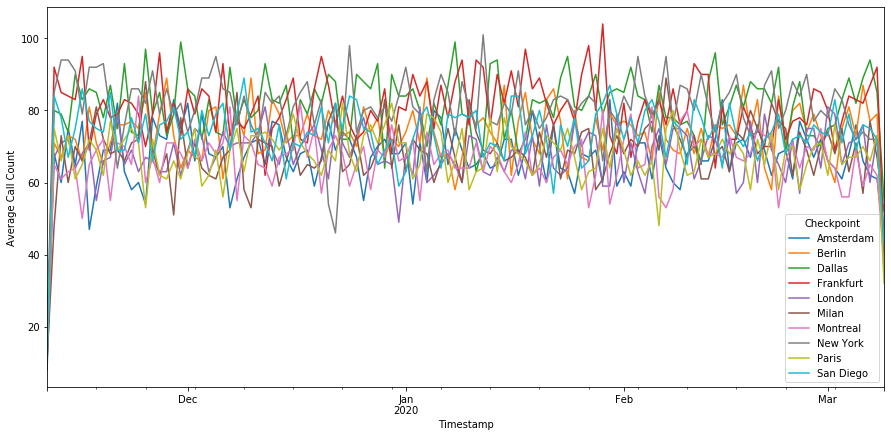

us-central1


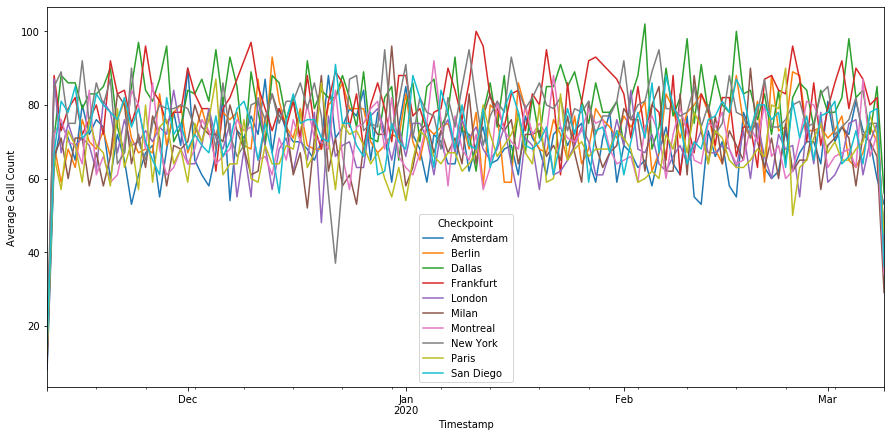

asia-east2


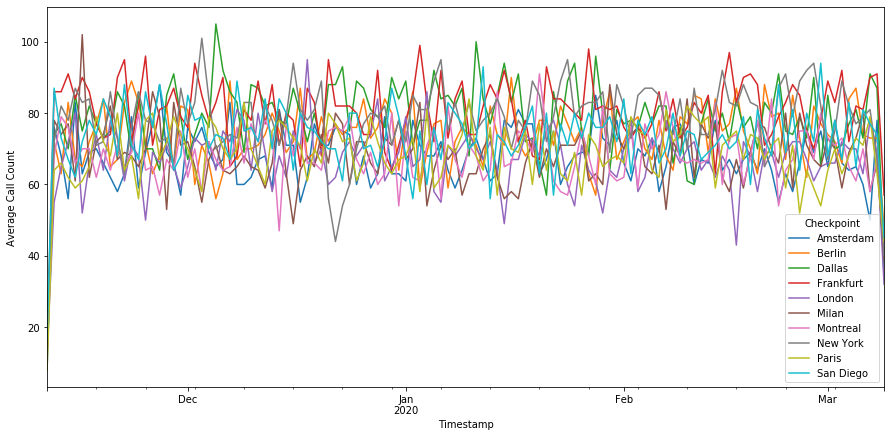

us-east1


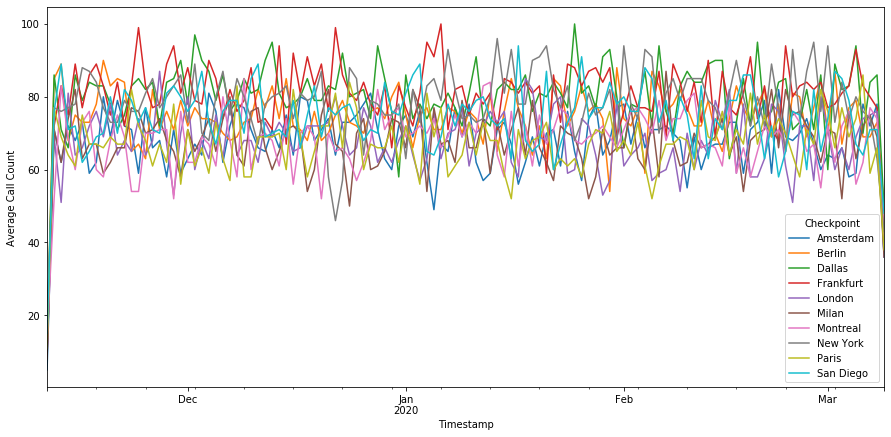

europe-west1


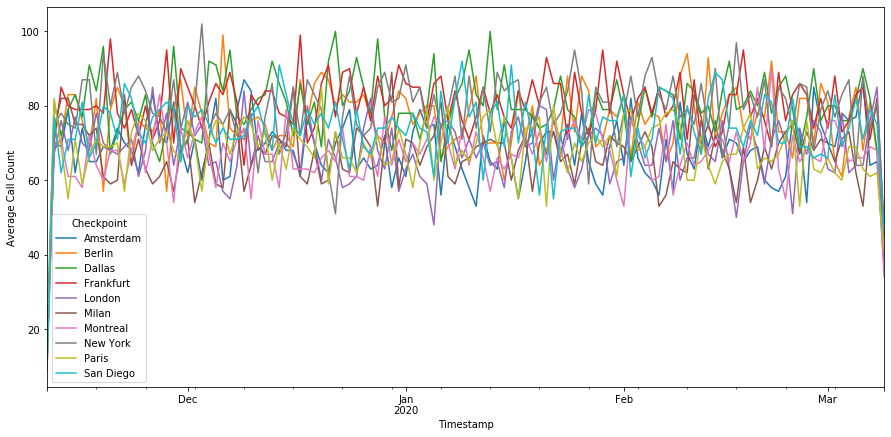

In [27]:
region_series = df['Region'].unique()
for region in region_series:
  print(region)  
  grouper = df.query("Region==@region").groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Checkpoint'])
  mean_result = grouper['RTT'].count().unstack() #필요시 .fillna(0) 추가

  fig, ax = plt.subplots(figsize=(15,7))
  mean_result.plot(ax=ax)
  plt.xlabel("Timestamp")
  plt.ylabel("Average Call Count")
  plt.show()

europe-west2


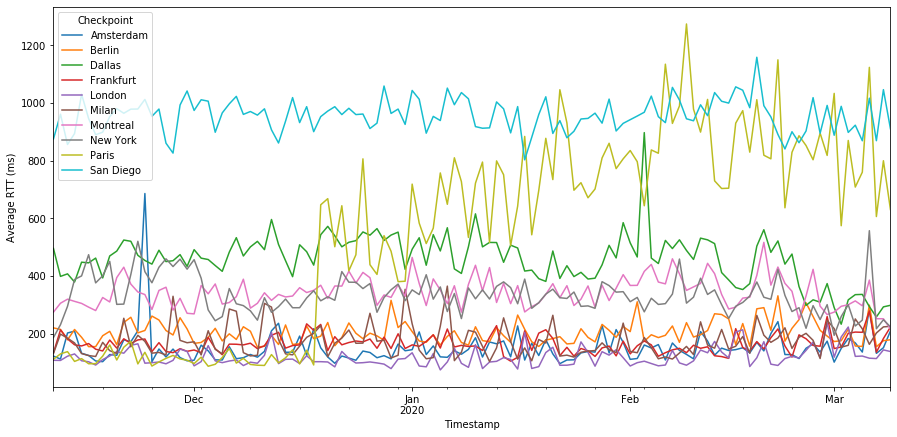

asia-northeast1


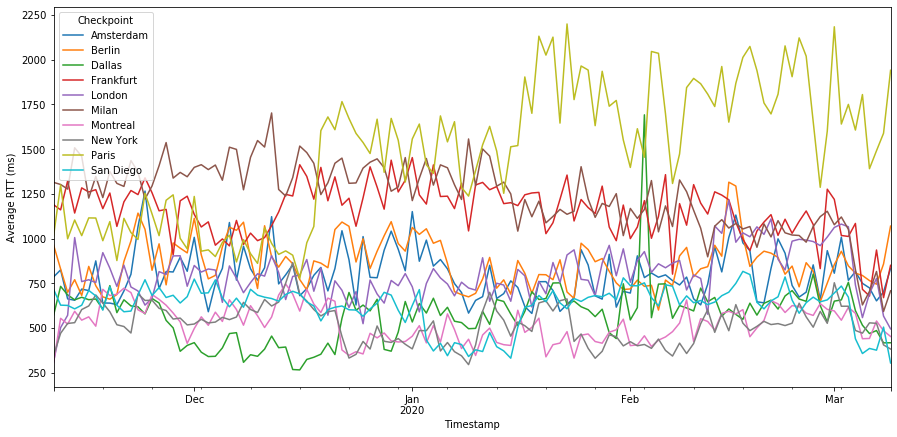

us-central1


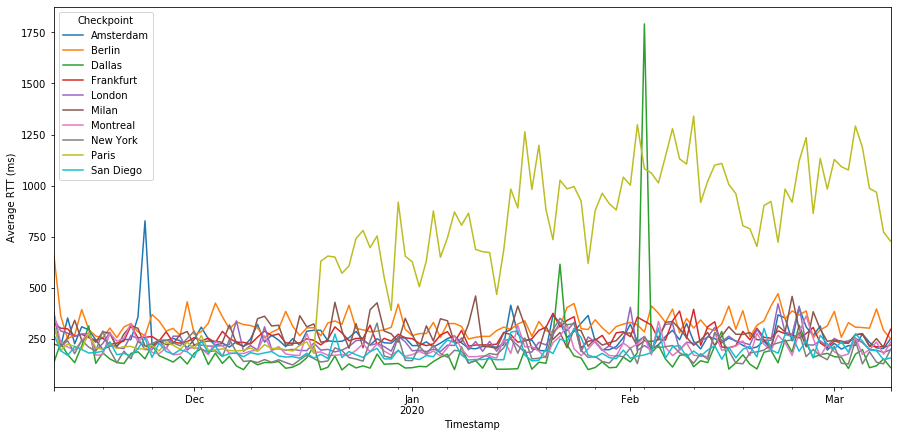

asia-east2


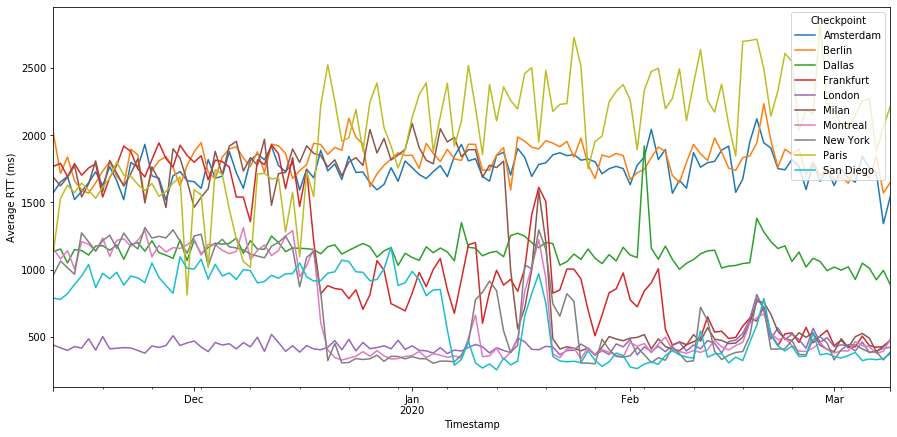

us-east1


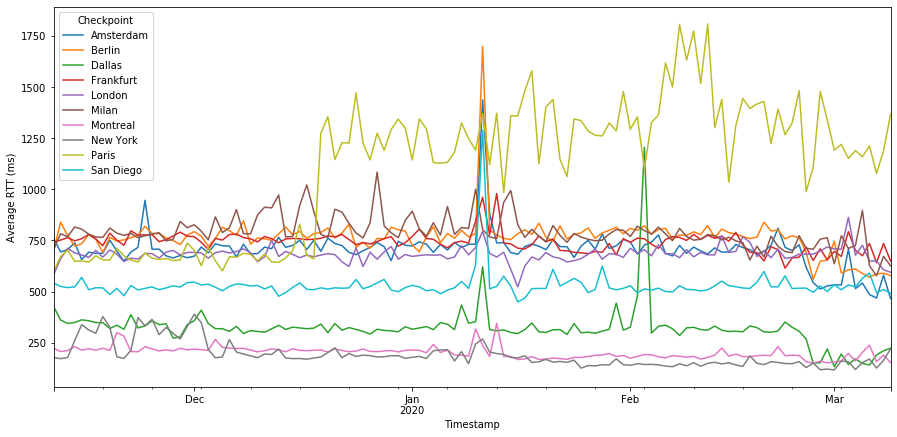

europe-west1


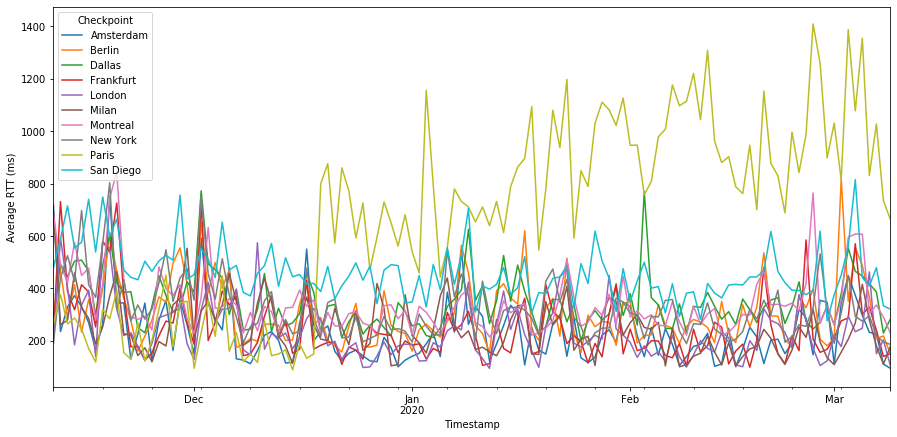

In [28]:
region_series = df['Region'].unique()
for region in region_series:
  print(region)  
  grouper = df.query("Region==@region").groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Checkpoint'])
  mean_result = grouper['RTT'].mean().unstack() #필요시 .fillna(0) 추가

  fig, ax = plt.subplots(figsize=(15,7))
  mean_result.plot(ax=ax)
  plt.xlabel("Timestamp")
  plt.ylabel("Average RTT (ms)")
  plt.show()

In [41]:
filtered_df = df.query(Region = '')

train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

TypeError: ignored

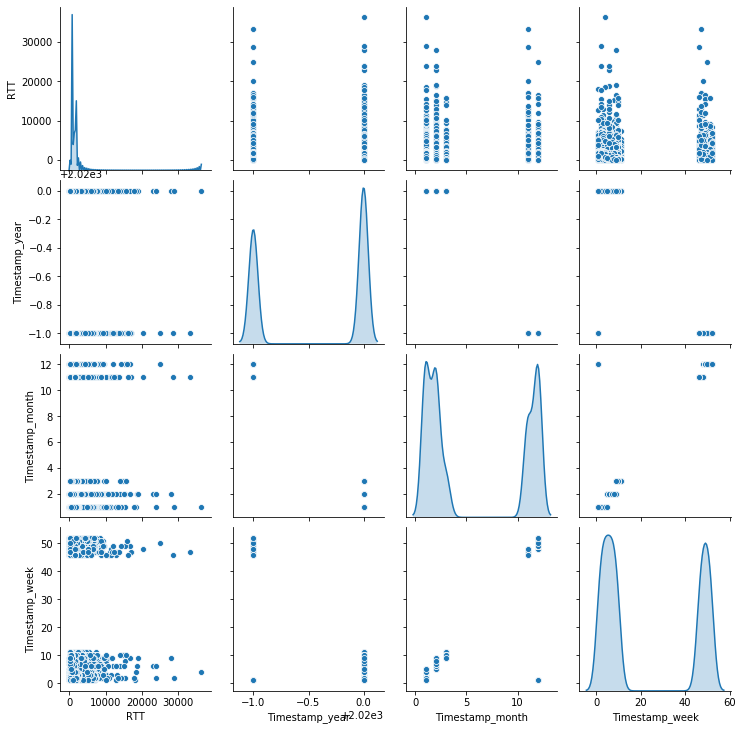

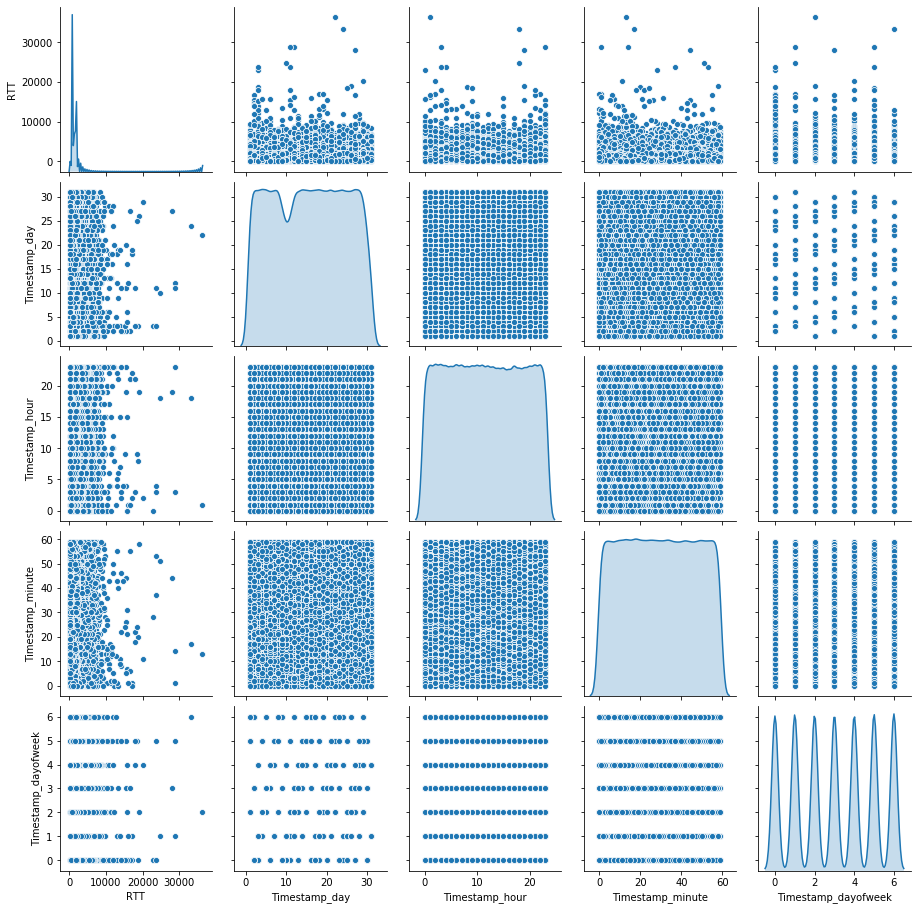

In [36]:
sns.pairplot(train[["RTT", "Timestamp_year", "Timestamp_month", "Timestamp_week"]], diag_kind="kde")
sns.pairplot(train[["RTT", "Timestamp_day", "Timestamp_hour", "Timestamp_minute", "Timestamp_dayofweek"]], diag_kind="kde")

In [37]:
train_stats = train.describe()
train_stats.pop("RTT")
train_stats = train_stats.transpose()
train_stats

count         mean        std  ...     50%     75%     max
Timestamp_year       334274.0  2019.577589   0.493944  ...  2020.0  2020.0  2020.0
Timestamp_month      334274.0     5.874570   4.950743  ...     2.0    12.0    12.0
Timestamp_week       334274.0    23.188887  21.518691  ...     9.0    48.0    52.0
Timestamp_day        334274.0    15.727457   8.798126  ...    16.0    23.0    31.0
Timestamp_hour       334274.0    11.479586   6.935416  ...    11.0    17.0    23.0
Timestamp_minute     334274.0    29.477252  17.310736  ...    29.0    44.0    59.0
Timestamp_dayofweek  334274.0     3.005708   1.997633  ...     3.0     5.0     6.0

[7 rows x 8 columns]

In [0]:
train_labels = train.pop('RTT')
test_labels = test.pop('RTT')

In [40]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

print(train)

normed_train_data = norm(train)
normed_test_data = norm(test)

normed_train_data.describe()

                 Timestamp  ... Timestamp_dayofweek
356479 2020-01-31 20:29:27  ...                   4
58923  2019-11-25 04:58:04  ...                   0
255712 2020-01-08 22:40:00  ...                   2
251522 2020-01-07 23:50:32  ...                   1
245411 2020-01-06 14:28:44  ...                   0
...                    ...  ...                 ...
336149 2020-01-27 05:39:13  ...                   0
435425 2020-02-18 18:58:21  ...                   1
25288  2019-11-17 13:44:03  ...                   6
185450 2019-12-23 22:30:43  ...                   0
487115 2020-03-01 13:13:40  ...                   6

[334274 rows x 10 columns]


TypeError: ignored